In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import subprocess
import pickle
from scipy.stats import describe
from tqdm import tqdm

from astropy.io import fits

from lvmdrp.core import image
from lvmdrp.functions import imageMethod

import seaborn as sns

sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# data root path
LVM_DEV = os.path.expandvars("$LVMHUB")
LVM_ROOT = os.path.join(LVM_DEV, "data.sdss5.org/sas/sdsswork/data/lvm")
LVM_DATA_LAB = os.path.join(LVM_ROOT, "lab")

In [3]:

frames_meta = pd.read_csv(os.path.join(LVM_DATA_LAB, "LVMI Exposure List - Sheet1.csv"))
frames_meta.filename = frames_meta.filename.str.strip()
frames_meta.set_index(["mjd","filename"], inplace=True)
frames_meta = frames_meta.loc[~frames_meta.index.duplicated(keep="first")]
frames_meta = frames_meta.mask(frames_meta==-999)
frames_meta = frames_meta.drop(columns=frames_meta.filter(like="Unnamed"))
frames_meta = frames_meta.dropna(how="all", axis="columns").dropna(how="all", axis="index")

print(f"No. lab frames: {len(frames_meta)}")

No. lab frames: 2381


In [4]:
frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if (pd.to_numeric(os.path.basename(root),errors="ignore"),file) in frames_meta.index])
# frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if file.endswith(".fits") or file.endswith(".fits.gz")])
print(f"frames matched in lab data path: {len(frame_paths)}")

frames matched in lab data path: 1922


In [5]:
frames_header_list_pickle = "frames_header_list.pk"

new_index = pd.MultiIndex.from_tuples(((pd.to_numeric(os.path.basename(os.path.dirname(file)),errors="ignore"),os.path.basename(file)) for file in frame_paths), names=("mjd", "filename"))
columns = "IMAGETYP CCDTEMP1 CCDTEMP2 PRESURE LABTEMP LABHUMID M625L4 FFS MI150 TS ARGON XENON HGAR LDLS KRYPTON NEON HGNE".split()

if os.path.isfile(frames_header_list_pickle):
    frames_header_list = pickle.load(open(frames_header_list_pickle, "rb"))
else:
    frames_header_list = []
    for idx, frame_path in tqdm(enumerate(frame_paths), total=len(frame_paths), desc="reading metadata from headers", ascii=True):
        try:
            hdr = fits.getheader(frame_path, ext=0)
        except OSError:
            continue
        
        frames_header_list.append([hdr.get(column, np.nan) for column in columns])
    
    pickle.dump(frames_header_list, open(frames_header_list_pickle, "wb"))

In [6]:
frames_header = pd.DataFrame(index=new_index, columns=columns, data=frames_header_list)
frames_header = frames_header.mask(frames_header==-999).mask(frames_header=="?")

frames_meta_match = frames_meta.loc[new_index]
frames_meta_match = pd.concat((frames_meta_match, frames_header), axis="columns")
frames_meta_match["filepath"] = frame_paths
frames_meta_match

exp_no        date location test_no  \
mjd   filename                                                         
59364 sdR-s-r1-00000318.fits.gz     318  30/05/2021      SBS     NaN   
59365 sdR-s-r1-00000325.fits.gz     325  31/05/2021      SBS     NaN   
      sdR-s-r1-00000326.fits.gz     326  31/05/2021      SBS     NaN   
      sdR-s-r1-00000327.fits.gz     327  31/05/2021      SBS     NaN   
      sdR-s-r1-00000328.fits.gz     328  31/05/2021      SBS     NaN   
...                                 ...         ...      ...     ...   
59543 sdR-s-z1-00001324.fits.gz    1324  25/11/2021      SBS     NaN   
      sdR-s-z1-00001325.fits.gz    1325  25/11/2021      SBS     NaN   
      sdR-s-z1-00001326.fits.gz    1326  25/11/2021      SBS     NaN   
      sdR-s-z1-00001327.fits.gz    1327  25/11/2021      SBS     NaN   
      sdR-s-z1-00001328.fits.gz    1328  25/11/2021      SBS     NaN   

                                test_iteration spec channel sources  \
mjd   filename                                                        
59364 sdR-s-r1-00000318.fits.gz            NaN  sp1      r1     NaN   
59365 sdR-s-r1-00000325.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000326.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000327.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000328.fits.gz            NaN  sp1      r1     NaN   
...                                        ...  ...     ...     ...   
59543 sdR-s-z1-00001324.fits.gz            NaN  sp1      z1    Neon   
      sdR-s-z1-00001325.fits.gz            NaN  sp1      z1    Neon   
      sdR-s-z1-00001326.fits.gz            NaN  sp1      z1   Argon   
      sdR-s-z1-00001327.fits.gz            NaN  sp1      z1   Argon   
      sdR-s-z1-00001328.fits.gz            NaN  sp1      z1   Argon   

                                lamp_current hartmanns  ... MI150   TS  ARGON  \
mjd   filename                                          ...                     
59364 sdR-s-r1-00000318.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
59365 sdR-s-r1-00000325.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
      sdR-s-r1-00000326.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
      sdR-s-r1-00000327.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
      sdR-s-r1-00000328.fits.gz          NaN       NaN  ...   NaN  NaN    NaN   
...                                      ...       ...  ...   ...  ...    ...   
59543 sdR-s-z1-00001324.fits.gz          NaN       NaN  ...   OFF  OFF    OFF   
      sdR-s-z1-00001325.fits.gz          NaN       NaN  ...   OFF  OFF    OFF   
      sdR-s-z1-00001326.fits.gz          NaN       NaN  ...   OFF  OFF     ON   
      sdR-s-z1-00001327.fits.gz          NaN       NaN  ...   OFF  OFF     ON   
      sdR-s-z1-00001328.fits.gz          NaN       NaN  ...   OFF  OFF     ON   

                                XENON HGAR LDLS KRYPTON NEON  HGNE  \
mjd   filename                                                       
59364 sdR-s-r1-00000318.fits.gz   NaN  NaN  NaN     NaN  NaN   NaN   
59365 sdR-s-r1-00000325.fits.gz   NaN  NaN  NaN     NaN  NaN   NaN   
      sdR-s-r1-00000326.fits.gz   NaN  NaN  NaN     NaN  NaN   NaN   
      sdR-s-r1-00000327.fits.gz   NaN  NaN  NaN     NaN  NaN   NaN   
      sdR-s-r1-00000328.fits.gz   NaN  NaN  NaN     NaN  NaN   NaN   
...                               ...  ...  ...     ...  ...   ...   
59543 sdR-s-z1-00001324.fits.gz   OFF  OFF  OFF     OFF   ON   OFF   
      sdR-s-z1-00001325.fits.gz   OFF  OFF  OFF     OFF   ON   OFF   
      sdR-s-z1-00001326.fits.gz   OFF  OFF  OFF     OFF  OFF   OFF   
      sdR-s-z1-00001327.fits.gz   OFF  OFF  OFF     OFF  OFF   OFF   
      sdR-s-z1-00001328.fits.gz   OFF  OFF  OFF     OFF  OFF   OFF   

                                                                          filepath  
mjd   filename                                                                      
59364 sdR-s-r1-00000318.fits.gz  /dis

<AxesSubplot:>

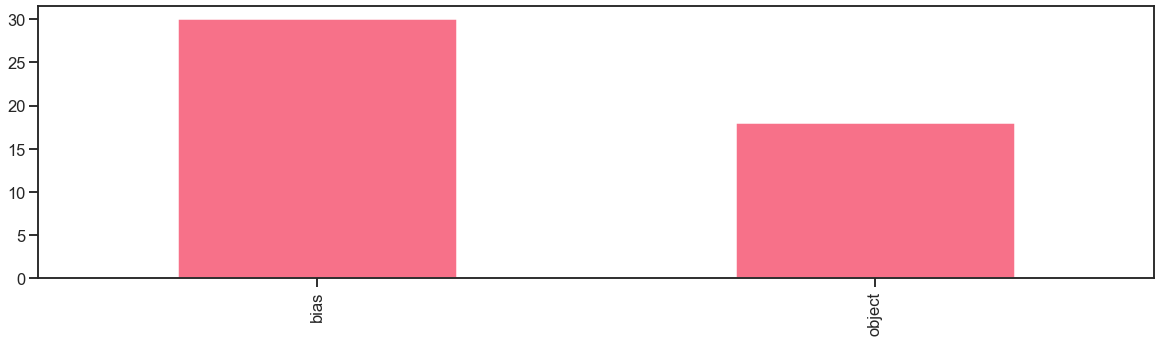

In [7]:
# clean_frames = frames_meta_match.loc[(pd.to_numeric(frames_meta_match.ccd_temp,errors="coerce")<0)&(~frames_meta_match.notes.fillna("").str.contains("bad", case=False))]
clean_frames = frames_meta_match.loc[frames_meta_match.exp_no.isin(np.arange(1313, 1328+1, dtype=int))]
clean_frames.IMAGETYP.value_counts().plot(kind="bar", figsize=(20,5))

In [20]:
clean_frames.loc[clean_frames.IMAGETYP=="object", ['M625L4', 'FFS', 'MI150', 'TS', 'ARGON', 'XENON', 'HGAR', 'LDLS', 'KRYPTON', 'NEON', 'HGNE']]=="ON"

M625L4    FFS  MI150     TS  ARGON  XENON  \
mjd   filename                                                               
59543 sdR-s-b1-00001323.fits.gz   False  False  False  False  False  False   
      sdR-s-b1-00001324.fits.gz   False  False  False  False  False  False   
      sdR-s-b1-00001325.fits.gz   False  False  False  False  False  False   
      sdR-s-b1-00001326.fits.gz   False  False  False  False   True  False   
      sdR-s-b1-00001327.fits.gz   False  False  False  False   True  False   
      sdR-s-b1-00001328.fits.gz   False  False  False  False   True  False   
      sdR-s-r1-00001323.fits.gz   False  False  False  False  False  False   
      sdR-s-r1-00001324.fits.gz   False  False  False  False  False  False   
      sdR-s-r1-00001325.fits.gz   False  False  False  False  False  False   
      sdR-s-r1-00001326.fits.gz   False  False  False  False   True  False   
      sdR-s-r1-00001327.fits.gz   False  False  False  False   True  False   
      sdR-s-r1-00001328.fits.gz   False  False  False  False   True  False   
      sdR-s-z1-00001323.fits.gz   False  False  False  False  False  False   
      sdR-s-z1-00001324.fits.gz   False  False  False  False  False  False   
      sdR-s-z1-00001325.fits.gz   False  False  False  False  False  False   
      sdR-s-z1-00001326.fits.gz   False  False  False  False   True  False   
      sdR-s-z1-00001327.fits.gz   False  False  False  False   True  False   
      sdR-s-z1-00001328.fits.gz   False  False  False  False   True  False   

                                  HGAR   LDLS  KRYPTON   NEON   HGNE  
mjd   filename                                                        
59543 sdR-s-b1-00001323.fits.gz  False  False    False   True  False  
      sdR-s-b1-00001324.fits.gz  False  False    False   True  False  
      sdR-s-b1-00001325.fits.gz  False  False    False   True  False  
      sdR-s-b1-00001326.fits.gz  False  False    False  False  False  
      sdR-s-b1-00001327.fits.gz  False  False    False  False  False  
      sdR-s-b1-00001328.fits.gz  False  False    False  False  False  
      sdR-s-r1-00001323.fits.gz  False  False    False   True  False  
      sdR-s-r1-00001324.fits.gz  False  False    False   True  False  
      sdR-s-r1-00001325.fits.gz  False  False    False   True  False  
      sdR-s-r1-00001326.fits.gz  False  False    False  False  False  
      sdR-s-r1-00001327.fits.gz  False  False    False  False  False  
      sdR-s-r1-00001328.fits.gz  False  False    False  False  False  
      sdR-s-z1-00001323.fits.gz  False  False    False   True  False  
      sdR-s-z1-00001324.fits.gz  False  False    False   True  False  
      sdR-s-z1-00001325.fits.gz  False  False    False   True  False  
      sdR-s-z1-00001326.fits.gz  False  False    False  False  False  
      sdR-s-z1-00001327.fits.gz  False  False    False  False  False  
      sdR-s-z1-00001328.fits.gz  False  False    False  False  False

In [9]:
dark_frames = clean_frames.loc[clean_frames.IMAGETYP=="dark"].sort_values("date", ascending=False)
bias_frames = clean_frames.loc[clean_frames.IMAGETYP=="bias"].sort_values("date", ascending=False)
flat_frames = clean_frames.loc[clean_frames.IMAGETYP=="flat"].sort_values("date", ascending=False)
lamp_frames = clean_frames.loc[clean_frames.IMAGETYP=="object"].sort_values("date", ascending=False)

In [10]:
iframe = -2
# frame = (59542, "sdR-s-r1-00001322.fits.gz")
cont_frame_path = clean_frames.iloc[iframe].filepath
# cont_frame_path = clean_frames.loc[frame].filepath
cont_frame_name = os.path.basename(cont_frame_path).replace(".fits.gz", "")
cont_frame_name

'sdR-s-z1-00001327'

In [25]:
cont_frame_path

'/disk-a/mejia/Research/UNAM/lvm-drp/data.sdss5.org/sas/sdsswork/data/lvm/lab/59543/sdR-s-z1-00001327.fits.gz'

In [11]:
# cont_frame = fits.open(cont_frame_path, memmap=False)
# cont_frame.info()

# data = cont_frame[0].data
# ny, nx = data.shape

# AMPLIFIER_WIDTH, AMPLIFIER_HEIGHT = nx//2, ny//2
# OVERSCAN_WIDTH = 20
# PRESCAN_WIDTH = 4
# AMPLIFIER_NAMES = list("abcd")

# fig_raw, axs_raw = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
# axs_raw = axs_raw.ravel()

# fig_cut, axs_cut = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
# axs_cut = axs_cut.ravel()

# amplifiers = dict.fromkeys(AMPLIFIER_NAMES)
# amplifiers["a"] = image.Image(data=data[AMPLIFIER_HEIGHT:,:AMPLIFIER_WIDTH])
# amplifiers["b"] = image.Image(data=data[AMPLIFIER_HEIGHT:,AMPLIFIER_WIDTH:])
# amplifiers["c"] = image.Image(data=data[:AMPLIFIER_HEIGHT,:AMPLIFIER_WIDTH])
# amplifiers["d"] = image.Image(data=data[:AMPLIFIER_HEIGHT,AMPLIFIER_WIDTH:])

# os_bias = dict.fromkeys(AMPLIFIER_NAMES)
# fr_bias = dict.fromkeys(AMPLIFIER_NAMES)
# for i, amp in enumerate(AMPLIFIER_NAMES):
#     axs_raw[i].imshow(amplifiers[amp]._data, origin="lower", cmap="plasma")
#     axs_raw[i].set_title(amp)
#     if amp in "ac":
#         os_bias[amp] = amplifiers[amp].cutOverscan(bound_x=(1,AMPLIFIER_HEIGHT), bound_y=(1,AMPLIFIER_WIDTH-OVERSCAN_WIDTH), subtract=True)
#     if amp in "bd":
#         os_bias[amp] = amplifiers[amp].cutOverscan(bound_x=(1+OVERSCAN_WIDTH,AMPLIFIER_WIDTH), bound_y=(1,AMPLIFIER_HEIGHT), subtract=True)
#     axs_cut[i].imshow(amplifiers[amp]._data, origin="lower", cmap="plasma")
#     axs_cut[i].set_title(amp)
    
#     print(f"final shape for amplifier region {amp}: {amplifiers[amp]._dim}")

# fig_raw.suptitle("Raw frame")
# fig_raw.tight_layout()
# fig_cut.suptitle("Trimmed frame")
# fig_cut.tight_layout()

# print(os_bias)

In [12]:
# As described in the article by van Dokkum a fine structure images is created to distinguish
# between cosmic rays hits and compact real signals that are almost undersampled on the CCD.
# For IFU data these are mainly emission lines from the sky or more importantly from the
# target objects itself.
# We defined a new fine structure map as the ratio between the Lapacian image and a Gaussian
# smoothed image with a width of the Gaussian matching the PSF of the spectrograph in dispersion
# AND cross-dispersion direction. If the given PSF is perfectly matching wtih the true PSF, a limit of
# flim>1 is the cutting line between true signal and cosmic ray hits.

imageMethod.LACosmic_drp(cont_frame_path, out_image=f"{cont_frame_name}.cosmic.fits", increase_radius=1, flim="1.3", parallel='10')

37 Fibers found


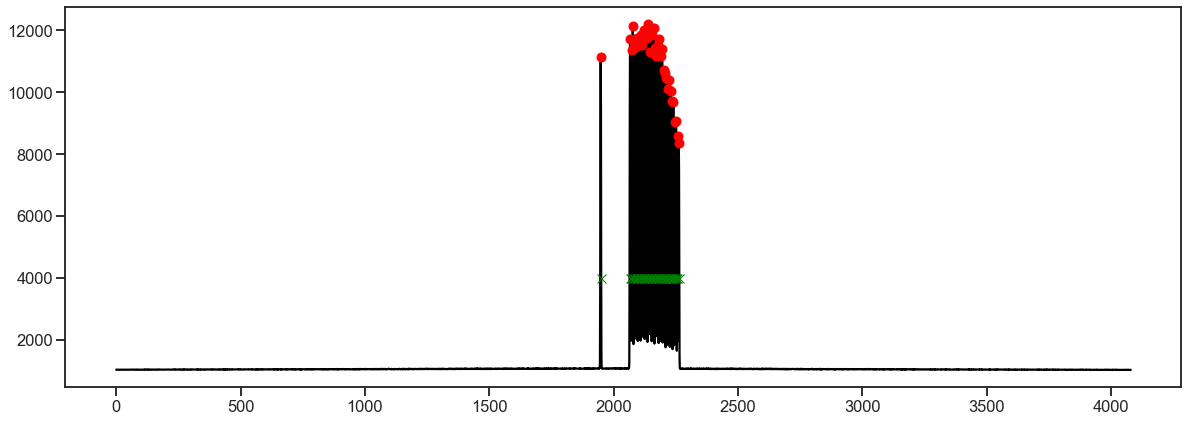

In [13]:
# Finds the exact subpixel cross-dispersion position of a given number of fibers at a certain dispersion column on the raw CCD frame.
# If a predefined number of pixel are expected, the initial threshold value for the minimum peak height will varied until the expected number
# pixels are detected.
# If instead the number of fibers is set to 0, all peaks above the threshold peak height value will be consider as fibers without further iterations.
# The results are stored in an ASCII file for further processing.
imageMethod.findPeaksAuto_drp(
    f"{cont_frame_name}.cosmic.fits",
    out_peaks_file=f"{cont_frame_name}.trace.peaks",
    disp_axis="X", threshold="5000", slice="3696", nfibers="37", median_box="1", median_cross="1", method="gauss", init_sigma="0.5", verbose=1)

Filename: sdR-s-z1-00001327.trc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (4120, 37)   float32   
  1  BADPIX        1 ImageHDU         8   (4120, 37)   uint8   


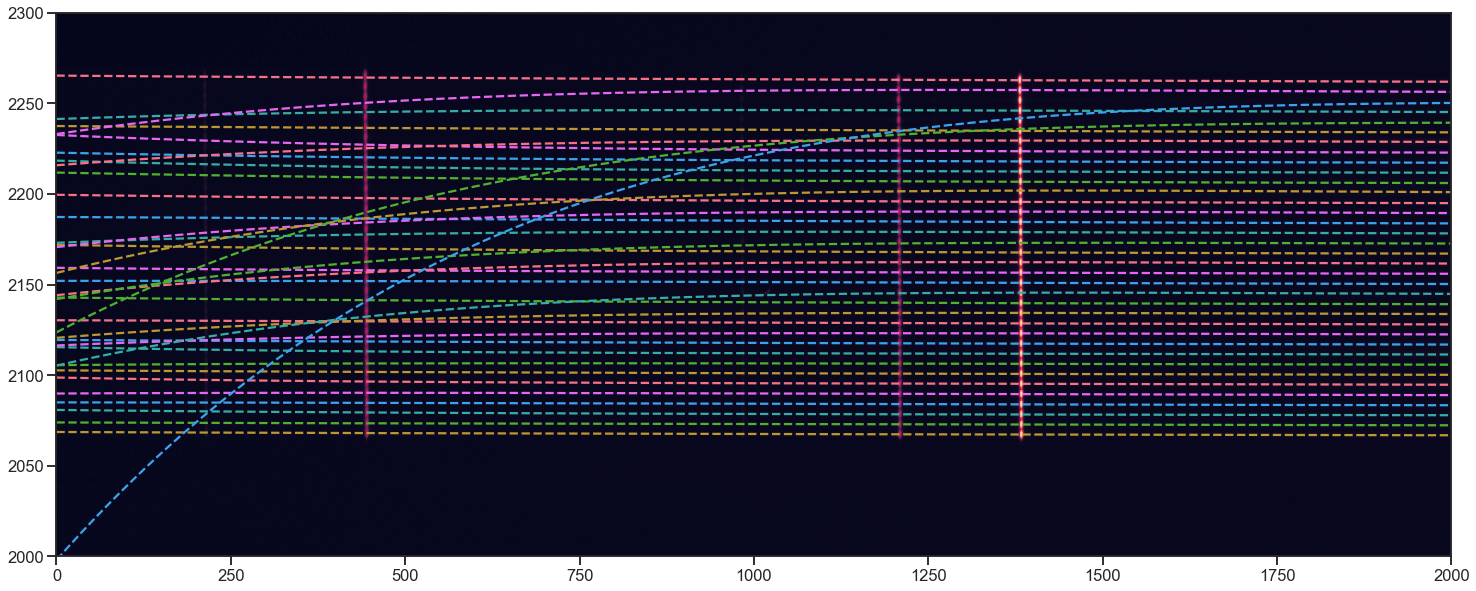

In [21]:
# Traces the peaks of fibers along the dispersion axis. The peaks at a specific dispersion column had to be determined before.
# Two scheme of measuring the subpixel peak positionare available: A hyperbolic approximation or fitting a Gaussian profile to the brightest 3 pixels of a peak.
# In both cases the resulting fiber traces along the dispersion axis are smoothed by modelling it with a polynomial function.
imageMethod.tracePeaks_drp(
    f"{cont_frame_name}.cosmic.fits",
    peaks_file=f"{cont_frame_name}.trace.peaks", trace_out=f"{cont_frame_name}.trc.fits",
    steps=30, method="gauss", threshold_peak=50, poly_disp=5, coadd=30, verbose=1)

cosmic = fits.open(f"{cont_frame_name}.cosmic.fits")
trace = fits.open(f"{cont_frame_name}.trc.fits")
trace.info()

plt.figure(figsize=(25,10))
plt.imshow(np.log10(cosmic[0].data), origin="lower")
plt.gca().set_aspect("auto")
plt.xlim(0,2000)
plt.ylim(2000,2300)

# plt.figure(figsize=(20,))
xx = np.arange(cosmic[0].data.shape[1])
for iy in range(trace[0].data.shape[0]):
    yy = trace[0].data[iy,:]
    plt.plot(xx, yy, "--")

In [22]:
# Subtracts a diffuse background signal (stray light) from the raw data. It uses the regions between fiber to estimate the stray light signal and
# smoothes the result by a polyon in cross-disperion direction and afterwards a wide 2D Gaussian filter to reduce the introduction of low frequency noise.
imageMethod.subtractStraylight_drp(
    f"{cont_frame_name}.cosmic.fits",
    f"{cont_frame_name}.trc.fits", f"{cont_frame_name}.back.fits", f"{cont_frame_name}.stray.fits",
    aperture=40, poly_cross=2, smooth_gauss=30)

subprocess.run(f"ds9 {cont_frame_name}.cosmic.fits {cont_frame_name}.stray.fits".split(), capture_output=True)

CompletedProcess(args=['ds9', 'sdR-s-z1-00001327.cosmic.fits', 'sdR-s-z1-00001327.stray.fits'], returncode=0, stdout=b'', stderr=b'')

In [23]:
# Measures the FWHM of the cross-dispersion fiber profile across the CCD.  It assumes that the profiles have a Gaussian shape and that the width  is CONSTANT for
# a BLOCK of fibers in cross-dispersion direction.  If the FITS image contains an extension with the error, the error frame will be taken into account in the Gaussian fitting.
# To increase the speed only the cross-dispersion profiles at certain position along the dispersion axis with a certain distance (steps)
# in pixels are modelled. The FWHM are then extrapolate by fitting a polynomial of given order along the dispersion axis.
imageMethod.traceFWHM_drp(
    f"{cont_frame_name}.stray.fits",
    f"{cont_frame_name}.trc.fits", f"{cont_frame_name}.fwhm.fits",
    blocks=32, steps=30, coadd=20, threshold_flux=50.0, poly_disp=5, clip="1.5,4.0")

subprocess.run(f"ds9 {cont_frame_name}.fwhm.fits".split(), capture_output=True)

CompletedProcess(args=['ds9', 'sdR-s-z1-00001327.fwhm.fits'], returncode=0, stdout=b'', stderr=b'')

In [24]:
# Extracts the flux for each fiber along the dispersion direction which is written into an RSS FITS file format.
# Either a simple aperture or an optimal extraction scheme may be used.
# In the optimal extraction scheme each cross-dispersion profile is fitted with independent Gaussian for each fiber where
# the position and fwhm is fixed according to the input parameters. This allows for a linear fitting scheme where only the fluxes per fiber
# are the only free parameter.
imageMethod.extractSpec_drp(
    f"{cont_frame_name}.stray.fits",
    f"{cont_frame_name}.trc.fits", f"{cont_frame_name}.ms.fits",
    method="optimal", fwhm=f"{cont_frame_name}.fwhm.fits", parallel=5)

subprocess.run(f"ds9 {cont_frame_name}.ms.fits".split(), capture_output=True)

CompletedProcess(args=['ds9', 'sdR-s-z1-00001327.ms.fits'], returncode=0, stdout=b'', stderr=b'')

In [19]:
# rss = fits.open(f"{cont_frame_name}.ms.fits")

# plt.figure(figsize=(20,5))
# plt.plot(rss[0].data[0])